In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from Tools.config_helpers import loadConfig, make_small
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_analysis import trilep_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [3]:
# an equivalent code can be run with ipython -i trilep_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small

overwrite = True
year      = 2018
small     = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_analysis_SS_2tight'
if small: cacheName += '_small'

cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
}

fileset = make_small(fileset, small, n_max=1)  # run over just one file each if small is set to true

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/274 [00:00<?, ?file/s]

Processing:   0%|          | 0/597 [00:00<?, ?chunk/s]

/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [4]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

processes.remove('topW_EFT_cp8')
processes.remove('topW_EFT_mix')

# the following list is directly taken from Tools/selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'MET>50',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,S/B
entry,231.4 +/- 0.2,15390.0 +/- 30.0,12660.0 +/- 10.0,11780.0 +/- 10.0,763800.0 +/- 300.0,4481000.0 +/- 1000.0,92540000.0 +/- 20000.0,0.0000
filter,231.1 +/- 0.2,15370.0 +/- 30.0,12650.0 +/- 10.0,11760.0 +/- 10.0,763400.0 +/- 300.0,4479000.0 +/- 1000.0,92520000.0 +/- 20000.0,0.0000
lepveto,30.7 +/- 0.09,477.9 +/- 3.2,1943.0 +/- 3.0,505.6 +/- 1.3,31590.0 +/- 50.0,98040.0 +/- 120.0,333300.0 +/- 1200.0,0.0001
trilep,5.583 +/- 0.038,66.85 +/- 0.78,201.9 +/- 1.1,60.85 +/- 0.43,3332.0 +/- 18.0,177.9 +/- 6.6,874.0 +/- 59.5,0.0012
p_T(lep0)>25,5.551 +/- 0.038,66.46 +/- 0.78,201.1 +/- 1.1,60.16 +/- 0.43,3285.0 +/- 18.0,174.5 +/- 6.5,830.2 +/- 57.8,0.0012
p_T(lep1)>20,5.347 +/- 0.037,64.04 +/- 0.77,195.2 +/- 1.1,56.51 +/- 0.42,3143.0 +/- 17.0,160.5 +/- 5.9,798.1 +/- 56.6,0.0012
trigger,4.928 +/- 0.036,58.85 +/- 0.74,183.4 +/- 1.0,51.2 +/- 0.4,2850.0 +/- 16.0,143.9 +/- 5.2,697.5 +/- 52.6,0.0012
offZ,4.928 +/- 0.036,58.85 +/- 0.74,183.4 +/- 1.0,51.2 +/- 0.4,2850.0 +/- 16.0,143.9 +/- 5.2,697.5 +/- 52.6,0.0012
MET>50,4.037 +/- 0.032,46.88 +/- 0.66,123.1 +/- 0.9,40.2 +/- 0.36,1440.0 +/- 12.0,96.82 +/- 4.02,111.4 +/- 20.0,0.0022
N_jet>2,3.851 +/- 0.031,38.63 +/- 0.61,112.5 +/- 0.8,35.94 +/- 0.34,438.6 +/- 6.7,57.51 +/- 2.98,31.81 +/- 10.14,0.0054


In [5]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9987,0.9987,0.9988,0.9987,0.9995,0.9996,0.9998
lepveto,0.1328,0.0311,0.1536,0.0430,0.0414,0.0219,0.0036
trilep,0.1818,0.1399,0.1039,0.1204,0.1055,0.0018,0.0026
p_T(lep0)>25,0.9944,0.9942,0.9958,0.9887,0.9859,0.9807,0.9499
p_T(lep1)>20,0.9632,0.9636,0.9709,0.9394,0.9568,0.9199,0.9613
trigger,0.9216,0.9189,0.9396,0.9060,0.9068,0.8965,0.8739
offZ,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
MET>50,0.8192,0.7967,0.6711,0.7852,0.5053,0.6730,0.1597
N_jet>2,0.9540,0.8240,0.9141,0.8941,0.3046,0.5939,0.2856


In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'EFT, cp8',
    'topW_EFT_mix': 'EFT mix',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
}

my_colors = {
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#000000',
    'topW_EFT_mix': '#0F7173',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',}

Data: 0 MC: 113.91


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


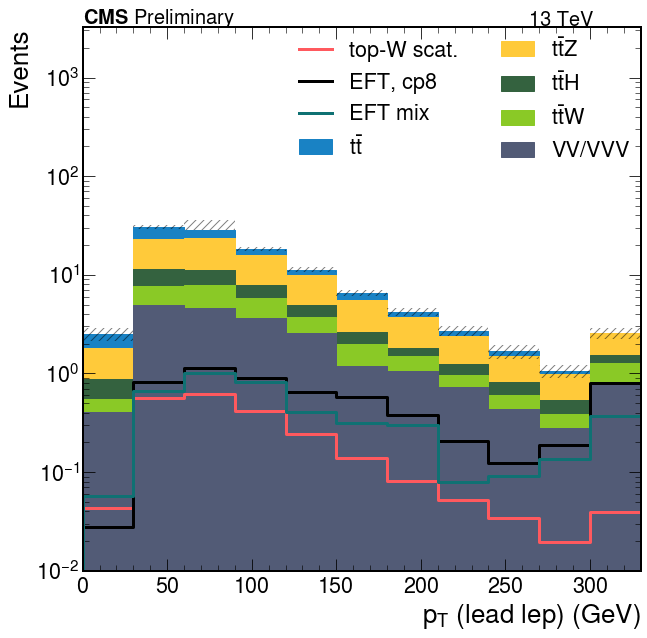

In [7]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=['topW_v3', 'topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 116.16


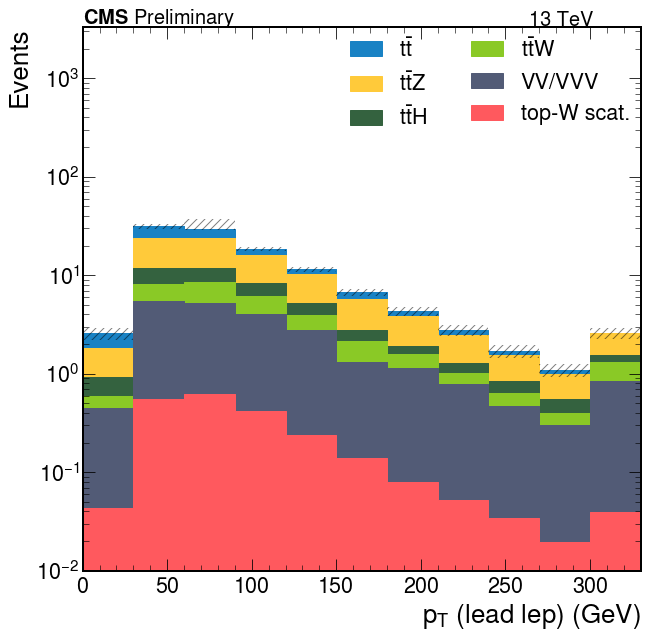

In [8]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 116.16


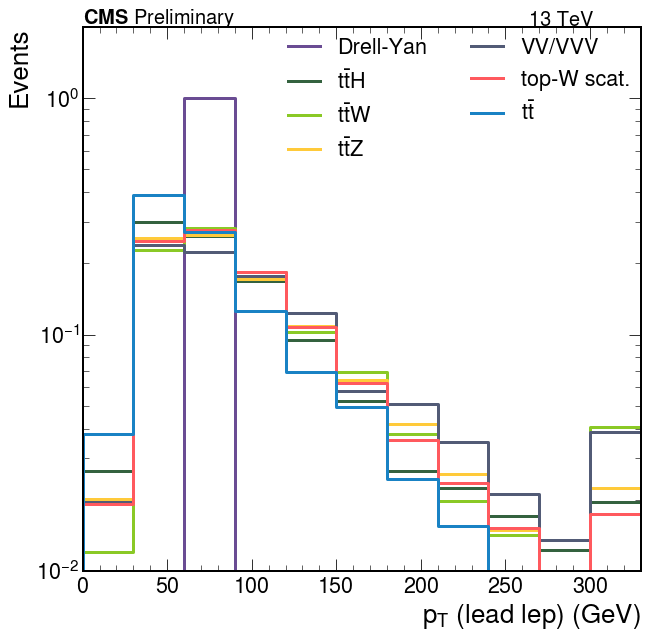

In [9]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 23.94


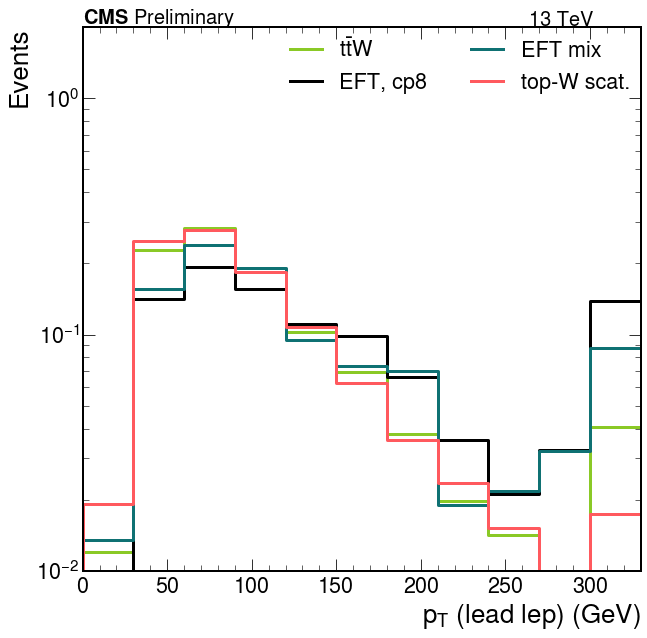

In [10]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['DY', 'ttbar', 'TTZ', 'TTH', 'diboson'],
        )

Data: 0 MC: 0.0
Data: 0 MC: 0.0


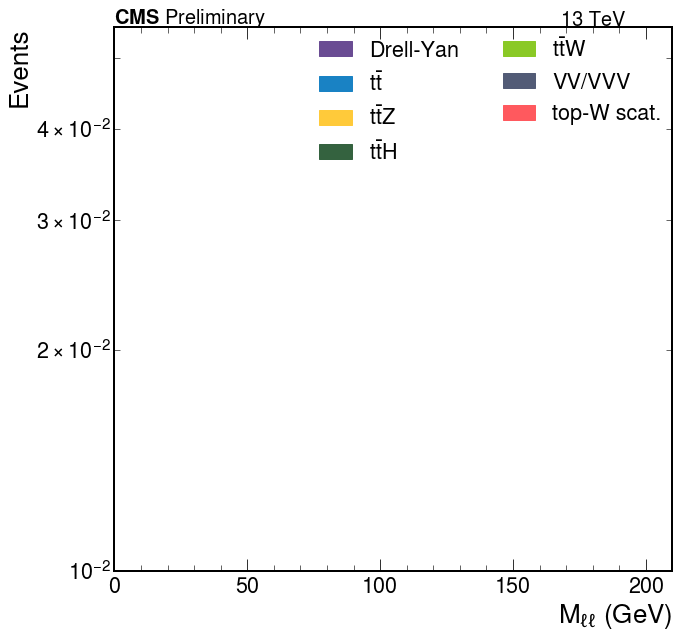

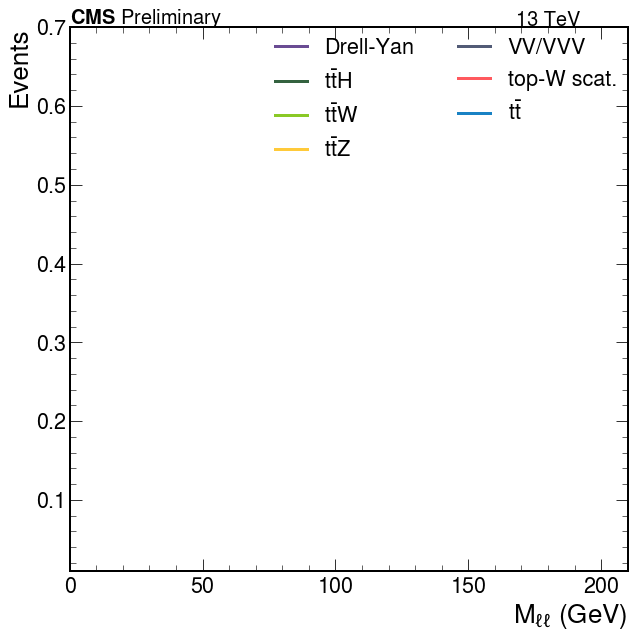

In [11]:
makePlot(output, 'dilep_mass', 'mass',
         bins=mass_bins, log=True, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson',  'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )
makePlot(output, 'dilep_mass', 'mass',
         shape=True,
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         ymax=0.7,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Here are the graphs:

Data: 0 MC: 116.16


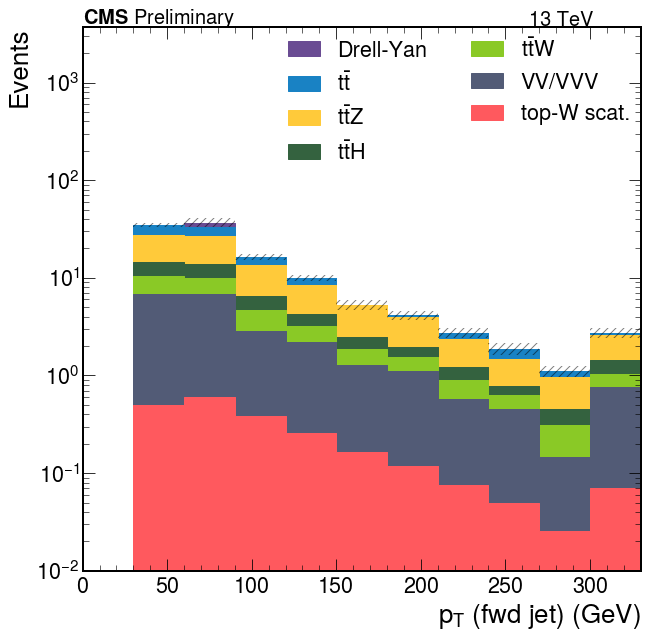

In [12]:
makePlot(output, 'fwd_jet', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (fwd jet) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 116.16


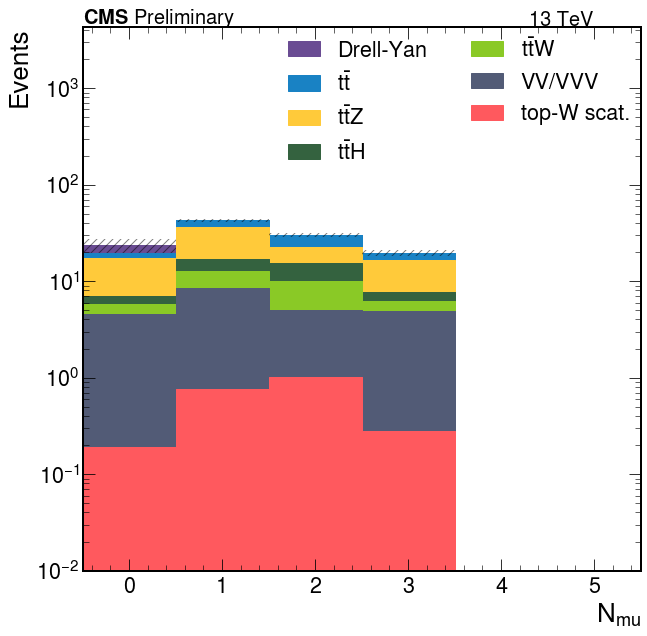

In [13]:
makePlot(output, 'N_mu', 'multiplicity',
         data=[],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{mu}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 116.16


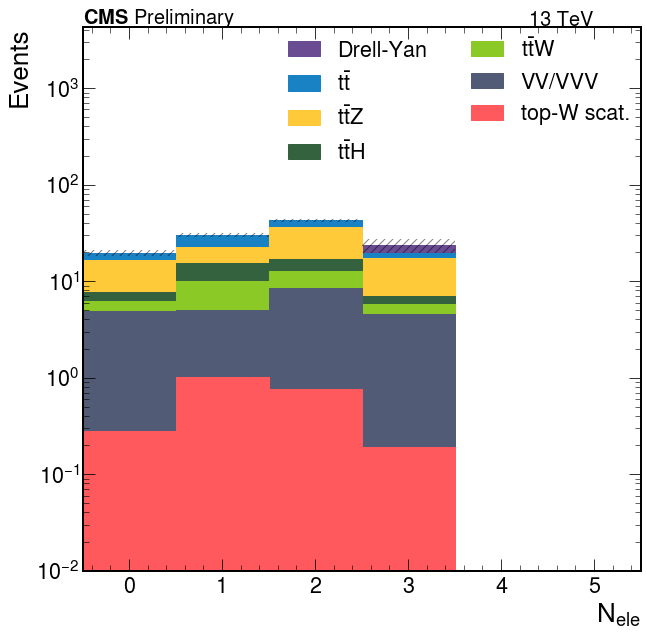

In [14]:
makePlot(output, 'N_ele', 'multiplicity',
         data=[],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{ele}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 116.16


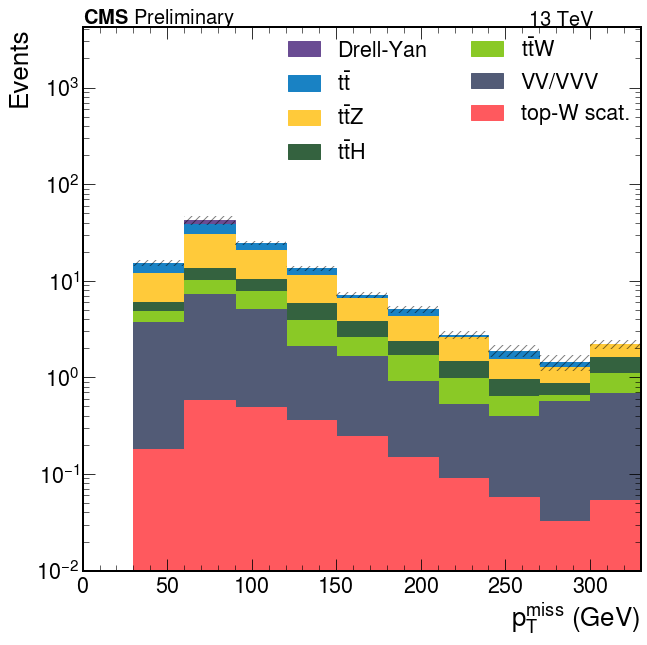

In [15]:
makePlot(output, 'MET', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}^{miss}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )